# Plotting

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

## Samples

In [7]:
function make_chain(samples::AbstractMatrix)
    return Chains(permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf])
end    

make_chain (generic function with 1 method)

In [8]:
#unmasked_hmc_samples = load("../chains/HMC/CMBLensing_unmasked", "_samples_hmc")
#masked_hmc_samples = load("../chains/HMC/CMBLensing_unmasked", "_samples_hmc");

In [9]:
#unmasked_mchmc_samples = load("../chains/MCHMC/CMBLensing_unmasked_TEV_0.001_NSIDE_64", "_samples_mchmc");
masked_mchmc_samples = load("../chains/MCHMC/CMBLensing_masked_TEV_0.0001", "samples");

In [10]:
#unmasked_mchmc_chain = make_chain(unmasked_mchmc_samples);
masked_mchmc_chain = make_chain(masked_mchmc_samples);

## Plotting

In [11]:
d = 12290

12290

In [12]:
#unmasked_mchmc_ess = MCMCDiagnosticTools.ess(unmasked_mchmc_chain)[[:r,:Aϕ],:ess]
#unmasked_mchmc_ess_per_call = unmasked_mchmc_ess / 10_000

LoadError: UndefVarError: `unmasked_mchmc_chain` not defined

In [14]:
masked_mchmc_ess = MCMCDiagnosticTools.ess(masked_mchmc_chain)[[:r,:Aϕ],:ess]
masked_mchmc_ess_per_call = masked_mchmc_ess / 10_000

2-element Vector{Float64}:
 0.005614388086038932
 0.006615545927402121

In [15]:
plot(unmasked_mchmc_chain[:r], label=L"r", xlabel="step")
plot!(unmasked_mchmc_chain[:Aϕ], label=L"A_\phi")

LoadError: UndefVarError: `unmasked_mchmc_chain` not defined

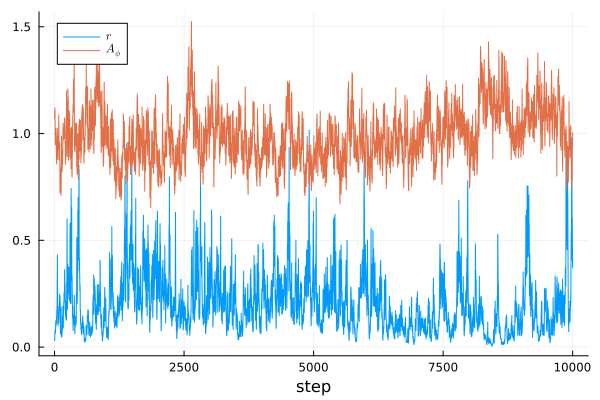

In [16]:
plot(masked_mchmc_chain[:r], label=L"r", xlabel="step")
plot!(masked_mchmc_chain[:Aϕ], label=L"A_\phi")

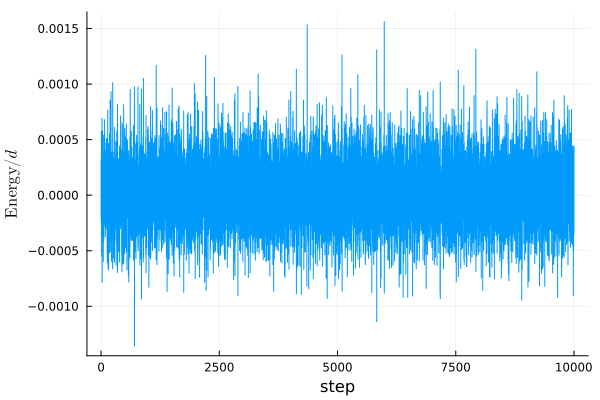

In [16]:
plot(unmasked_mchmc_chain[:dE]/d, ylabel=L"\mathrm{Energy}/d", xlabel="step", label=nothing)

In [17]:
histogram2d(unmasked_mchmc_chain[:r], unmasked_mchmc_chain[:Aϕ], bins=(40, 40), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Unmasked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

LoadError: UndefVarError: `unmasked_mchmc_chain` not defined

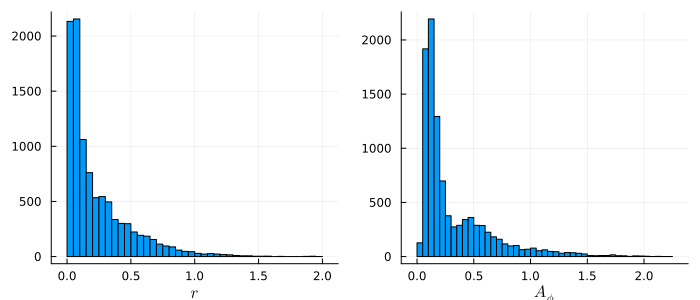

In [18]:
plot(histogram(unmasked_mchmc_chain[:r], xlabel=L"r", label=nothing, lw=1),
     histogram(unmasked_mchmc_chain[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
     size = (700,300))
plot!(histogram(masked_mchmc_chain[:r], xlabel=L"r", label=nothing, lw=1),
     histogram(masked_mchmc_chain[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
     size = (700,300))